# **Copy Data from Drive to Colab Hard**

In [3]:
!cp /content/drive/MyDrive/Masoudi/dataset.zip .

In [4]:
!unzip -qq dataset.zip

# **util: Helper Code**

In [ ]:
#!/usr/bin/env python

# Do *not* edit this script.
# These are helper functions that you can use with your code.
# Check the example code to see how to import these functions to your code.

import os, numpy as np, scipy as sp, scipy.io

### Challenge data I/O functions

# Find the folders with data files.
def find_data_folders(root_folder):
    data_folders = list()
    for x in os.listdir(root_folder):
        data_folder = os.path.join(root_folder, x)
        if os.path.isdir(data_folder):
            data_folders.append(x)
    return sorted(data_folders)

def load_challenge_data(data_folder, patient_id):
    # Define file location.
    patient_metadata_file = os.path.join(data_folder, patient_id, patient_id + '.txt')
    recording_metadata_file = os.path.join(data_folder, patient_id, patient_id + '.tsv')

    # Load non-recording data.
    patient_metadata = load_text_file(patient_metadata_file)
    recording_metadata = load_text_file(recording_metadata_file)

    # Load recordings.
    recordings = list()
    recording_ids = get_recording_ids(recording_metadata)
    for recording_id in recording_ids:
        if recording_id != 'nan':
            recording_location = os.path.join(data_folder, patient_id, recording_id)
            recording_data, sampling_frequency, channels = load_recording(recording_location)
        else:
            recording_data = None
            sampling_frequency = None
            channels = None
        recordings.append((recording_data, sampling_frequency, channels))

    return patient_metadata, recording_metadata, recordings

# Load the WFDB data for the Challenge (but not all possible WFDB files).
def load_recording(record_name):
    # Allow either the record name or the header filename.
    root, ext = os.path.splitext(record_name)
    if ext=='':
        header_file = record_name + '.hea'
    else:
        header_file = record_name

    # Load the header file.
    if not os.path.isfile(header_file):
        raise FileNotFoundError('{} recording not found.'.format(record_name))

    with open(header_file, 'r') as f:
        header = [l.strip() for l in f.readlines() if l.strip()]

    # Parse the header file.
    record_name = None
    num_signals = None
    sampling_frequency = None
    num_samples = None
    signal_files = list()
    gains = list()
    offsets = list()
    channels = list()
    initial_values = list()
    checksums = list()

    for i, l in enumerate(header):
        arrs = [arr.strip() for arr in l.split(' ')]
        # Parse the record line.
        if i==0:
            record_name = arrs[0]
            num_signals = int(arrs[1])
            sampling_frequency = float(arrs[2])
            num_samples = int(arrs[3])
        # Parse the signal specification lines.
        else:
            signal_file = arrs[0]
            gain = float(arrs[2].split('/')[0])
            offset = int(arrs[4])
            initial_value = int(arrs[5])
            checksum = int(arrs[6])
            channel = arrs[8]
            signal_files.append(signal_file)
            gains.append(gain)
            offsets.append(offset)
            initial_values.append(initial_value)
            checksums.append(checksum)
            channels.append(channel)

    # Check that the header file only references one signal file. WFDB format  allows for multiple signal files, but we have not
    # implemented that here for simplicity.
    num_signal_files = len(set(signal_files))
    if num_signal_files!=1:
        raise NotImplementedError('The header file {}'.format(header_file) \
            + ' references {} signal files; one signal file expected.'.format(num_signal_files))

    # Load the signal file.
    head, tail = os.path.split(header_file)
    signal_file = os.path.join(head, list(signal_files)[0])
    data = np.asarray(sp.io.loadmat(signal_file)['val'])

    # Check that the dimensions of the signal data in the signal file is consistent with the dimensions for the signal data given
    # in the header file.
    num_channels = len(channels)
    if np.shape(data)!=(num_channels, num_samples):
        raise ValueError('The header file {}'.format(header_file) \
            + ' is inconsistent with the dimensions of the signal file.')

    # Check that the initial value and checksums for the signal data in the signal file are consistent with the initial value and
    # checksums for the signal data given in the header file.
    for i in range(num_channels):
        if data[i, 0]!=initial_values[i]:
            raise ValueError('The initial value in header file {}'.format(header_file) \
                + ' is inconsistent with the initial value for channel'.format(channels[i]))
        if np.sum(data[i, :])!=checksums[i]:
            raise ValueError('The checksum in header file {}'.format(header_file) \
                + ' is inconsistent with the initial value for channel'.format(channels[i]))

    # Rescale the signal data using the ADC gains and ADC offsets.
    rescaled_data = np.zeros(np.shape(data), dtype=np.float32)
    for i in range(num_channels):
        rescaled_data[i, :] = (data[i, :]-offsets[i])/gains[i]

    return rescaled_data, sampling_frequency, channels

# Reorder/reselect the channels.
def reorder_recording_channels(current_data, current_channels, reordered_channels):
    if current_channels == reordered_channels:
        return current_data
    else:
        indices = list()
        for channel in reordered_channels:
            if channel in current_channels:
                i = current_channels.index(channel)
                indices.append(i)
        num_channels = len(reordered_channels)
        num_samples = np.shape(current_data)[1]
        reordered_data = np.zeros((num_channels, num_samples))
        reordered_data[:, :] = current_data[indices, :]
        return reordered_data

### Helper Challenge data I/O functions

# Load text file as a string.
def load_text_file(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data

# Get a variable from the patient metadata.
def get_variable(text, variable_name, variable_type, preserve_nan=True):
    variable = None
    for l in text.split('\n'):
        if l.startswith(variable_name):
            variable = l.split(':')[1].strip()
            if preserve_nan and variable.lower() == 'nan':
                variable = float('nan')
            else:
                variable = variable_type(variable)
            return variable

# Get a column from the recording metadata.
def get_column(string, column, variable_type, sep='\t'):
    variables = list()
    for i, l in enumerate(string.split('\n')):
        arrs = [arr.strip() for arr in l.split(sep) if arr.strip()]
        if i==0:
            column_index = arrs.index(column)
        elif arrs:
            variable = arrs[column_index]
            variable = variable_type(variable)
            variables.append(variable)
    return np.asarray(variables)

# Get the patient ID variable from the patient data.
def get_patient_id(string):
    return get_variable(string, 'Patient', str)

# Get the age variable (in years) from the patient data.
def get_age(string):
    return get_variable(string, 'Age', int)

# Get the sex variable from the patient data.
def get_sex(string):
    return get_variable(string, 'Sex', str)

# Get the ROSC variable (in minutes) from the patient data.
def get_rosc(string):
    return get_variable(string, 'ROSC', int)

# Get the OHCA variable from the patient data.
def get_ohca(string):
    return get_variable(string, 'OHCA', bool)

# Get the VFib variable from the patient data.
def get_vfib(string):
    return get_variable(string, 'VFib', bool)

# Get the TTM variable (in Celsius) from the patient data.
def get_ttm(string):
    return get_variable(string, 'TTM', int)

# Get the Outcome variable from the patient data.
def get_outcome(string):
    variable = get_variable(string, 'Outcome', str)
    if variable is None or is_nan(variable):
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    if variable == 'Good':
        variable = 0
    elif variable == 'Poor':
        variable = 1
    return variable

# Get the Outcome probability variable from the patient data.
def get_outcome_probability(string):
    variable = sanitize_scalar_value(get_variable(string, 'Outcome probability', str))
    if variable is None or is_nan(variable):
        raise ValueError('No outcome available. Is your code trying to load labels from the hidden data?')
    return variable

# Get the CPC variable from the patient data.
def get_cpc(string):
    variable = sanitize_scalar_value(get_variable(string, 'CPC', str))
    if variable is None or is_nan(variable):
        raise ValueError('No CPC score available. Is your code trying to load labels from the hidden data?')
    return variable

# Get the hour number column from the patient data.
def get_hours(string):
    return get_column(string, 'Hour', int)

# Get the time column from the patient data.
def get_times(string):
    return get_column(string, 'Time', str)

# Get the quality score column from the patient data.
def get_quality_scores(string):
    return get_column(string, 'Quality', float)

# Get the recording IDs column from the patient data.
def get_recording_ids(string):
    return get_column(string, 'Record', str)

### Challenge label and output I/O functions

# Load the Challenge labels for one file.
def load_challenge_label(string):
    if os.path.isfile(string):
        string = load_text_file(string)

    outcome = get_outcome(string)
    cpc = get_cpc(string)

    return outcome, cpc

# Load the Challenge labels for all of the files in a folder.
def load_challenge_labels(folder):
    patient_folders = find_data_folders(folder)
    num_patients = len(patient_folders)

    patient_ids = list()
    outcomes = np.zeros(num_patients, dtype=np.bool_)
    cpcs = np.zeros(num_patients, dtype=np.float64)

    for i in range(num_patients):
        patient_metadata_file = os.path.join(folder, patient_folders[i], patient_folders[i] + '.txt')
        patient_metadata = load_text_file(patient_metadata_file)

        patient_ids.append(get_patient_id(patient_metadata))
        outcomes[i] = get_outcome(patient_metadata)
        cpcs[i] = get_cpc(patient_metadata)

    return patient_ids, outcomes, cpcs

# Save the Challenge outputs for one file.
def save_challenge_outputs(filename, patient_id, outcome, outcome_probability, cpc):
    # Sanitize values, e.g., in case they are a singleton array.
    outcome = sanitize_boolean_value(outcome)
    outcome_probability = sanitize_scalar_value(outcome_probability)
    cpc = sanitize_scalar_value(cpc)

    # Format Challenge outputs.
    patient_string = 'Patient: {}'.format(patient_id)
    if outcome == 0:
        outcome = 'Good'
    elif outcome == 1:
        outcome = 'Poor'
    outcome_string = 'Outcome: {}'.format(outcome)
    outcome_probability_string = 'Outcome probability: {:.3f}'.format(float(outcome_probability))
    cpc_string = 'CPC: {:.3f}'.format(int(float(cpc)) if is_integer(cpc) else float(cpc))
    output_string = patient_string + '\n' + \
        outcome_string + '\n' + outcome_probability_string + '\n' + cpc_string + '\n'

    # Write the Challenge outputs.
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(output_string)

    return output_string

# Load the Challenge outputs for one file.
def load_challenge_output(string):
    if os.path.isfile(string):
        string = load_text_file(string)

    patient_id = get_patient_id(string)
    outcome = get_outcome(string)
    outcome_probability = get_outcome_probability(string)
    cpc = get_cpc(string)

    return patient_id, outcome, outcome_probability, cpc

# Load the Challenge outputs for all of the files in folder.
def load_challenge_outputs(folder, patient_ids):
    num_patients = len(patient_ids)
    outcomes = np.zeros(num_patients, dtype=np.bool_)
    outcome_probabilities = np.zeros(num_patients, dtype=np.float64)
    cpcs = np.zeros(num_patients, dtype=np.float64)

    for i in range(num_patients):
        output_file = os.path.join(folder, patient_ids[i], patient_ids[i] + '.txt')
        patient_id, outcome, outcome_probability, cpc = load_challenge_output(output_file)
        outcomes[i] = outcome
        outcome_probabilities[i] = outcome_probability
        cpcs[i] = cpc

    return outcomes, outcome_probabilities, cpcs

### Other helper functions

# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# Check if a variable is a NaN (not a number) or represents a NaN.
def is_nan(x):
    if is_number(x):
        return np.isnan(float(x))
    else:
        return False

# Remove any quotes, brackets (for singleton arrays), and/or invisible characters.
def remove_extra_characters(x):
    return str(x).replace('"', '').replace("'", "").replace('[', '').replace(']', '').replace(' ', '').strip()

# Sanitize boolean values, e.g., from the Challenge outputs.
def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_finite_number(x) and float(x)==0) or (x in ('False', 'false', 'F', 'f')):
        return 0
    elif (is_finite_number(x) and float(x)==1) or (x in ('True', 'true', 'T', 't')):
        return 1
    else:
        return float('nan')

# Santize scalar values, e.g., from the Challenge outputs.
def sanitize_scalar_value(x):
    x = remove_extra_characters(x)
    if is_number(x):
        return float(x)
    else:
        return float('nan')

In [ ]:
!pip install -q mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.1 MB/s eta 0:00:00


In [ ]:
import mne
from sklearn.preprocessing import StandardScaler
def get_features(patient_metadata, recording_metadata, recording_data):
    # Extract features from the patient metadata.
    age = get_age(patient_metadata)
    sex = get_sex(patient_metadata)
    rosc = get_rosc(patient_metadata)
    ohca = get_ohca(patient_metadata)
    vfib = get_vfib(patient_metadata)
    ttm = get_ttm(patient_metadata)

    # Use one-hot encoding for sex; add more variables
    sex_features = np.zeros(2, dtype=int)
    if sex == 'Female':
        female = 1
        male   = 0
        other  = 0
    elif sex == 'Male':
        female = 0
        male   = 1
        other  = 0
    else:
        female = 0
        male   = 0
        other  = 1

    # Combine the patient features.
    patient_features = np.array([age, female, male, other, rosc, ohca, vfib, ttm])

    # Extract features from the recording data and metadata.
    channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3',
                'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
    num_channels = len(channels)
    num_recordings = len(recording_data)
    print('LENGTH OF RECORDED DATASET', num_recordings)

    # Compute mean and standard deviation for each channel for each recording.
    available_signal_data = list()
    for i in range(num_recordings):
        signal_data, sampling_frequency, signal_channels = recording_data[i]
        if signal_data is not None:
            signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.
            available_signal_data.append(signal_data)

    if len(available_signal_data) > 0:
        available_signal_data = np.hstack(available_signal_data)
        signal_mean = np.nanmean(available_signal_data, axis=1)
        signal_std  = np.nanstd(available_signal_data, axis=1)
    else:
        signal_mean = float('nan') * np.ones(num_channels)
        signal_std  = float('nan') * np.ones(num_channels)

    # Compute the power spectral density for the delta, theta, alpha, and beta frequency bands for each channel of the most
    # recent recording.
    index = None
    for i in reversed(range(num_recordings)):
        signal_data, sampling_frequency, signal_channels = recording_data[i]
        if signal_data is not None:
            index = i
            break

    if index is not None:
        signal_data, sampling_frequency, signal_channels = recording_data[index]
        signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.

        delta_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=0.5,  fmax=8.0, verbose=False)
        theta_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=4.0,  fmax=8.0, verbose=False)
        alpha_psd, _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency,  fmin=8.0, fmax=12.0, verbose=False)
        beta_psd,  _ = mne.time_frequency.psd_array_welch(signal_data, sfreq=sampling_frequency, fmin=12.0, fmax=30.0, verbose=False)

        delta_psd_mean = np.nanmean(delta_psd, axis=1)
        theta_psd_mean = np.nanmean(theta_psd, axis=1)
        alpha_psd_mean = np.nanmean(alpha_psd, axis=1)
        beta_psd_mean  = np.nanmean(beta_psd,  axis=1)

        quality_score = get_quality_scores(recording_metadata)[index]
    else:
        delta_psd_mean = theta_psd_mean = alpha_psd_mean = beta_psd_mean = float('nan') * np.ones(num_channels)
        quality_score = float('nan')

    recording_features = np.hstack((signal_mean, signal_std, delta_psd_mean, theta_psd_mean, alpha_psd_mean, beta_psd_mean, quality_score))

    # Combine the features from the patient metadata and the recording data and metadata.
    features = np.hstack((patient_features, recording_features))

    return features

In [ ]:
def get_EEG(recording_data):
  channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3',
                'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
  num_channels = len(channels)
  num_recordings = len(recording_data)
  print('LENGTH OF RECORDED DATASET', num_recordings)

    # Compute mean and standard deviation for each channel for each recording.
  available_signal_data = list()
  for i in range(num_recordings):
    signal_data, sampling_frequency, signal_channels = recording_data[i]
    if signal_data is not None:
      signal_data = reorder_recording_channels(signal_data, signal_channels, channels) # Reorder the channels in the signal data, as needed, for consistency across different recordings.
      available_signal_data.append(signal_data)
    if len(available_signal_data) > 0:
        available_signal_data1 = np.hstack(available_signal_data)  
  return available_signal_data1    


In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [ ]:
data_folder = "/content/i-care-international-cardiac-arrest-research-consortium-database-1.0/training"

In [ ]:
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)

In [ ]:
print(num_patients)

607


# ***Extratcing dataset***

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
outcomes = list()
cpcs = list()
Cobmined_EEG_12 = list()
Cobmined_EEG_24 = list()
#Cobmined_EEG_36 = list()
for j in range(607):
    print('    {}/{}...'.format(j+1, num_patients))
    patient_id = patient_ids[j]
    patient_metadata, recording_metadata, recording_data = load_challenge_data(data_folder, patient_id)
    #EEG_features.append(get_EEG(recording_data))

    total = 0
    for i in range(18):
      filtered_EEG =  np.array(get_EEG(recording_data)[i])
      total += filtered_EEG  
    Cobmined_EEG_12.append(total[0:60*60*12])
    Cobmined_EEG_24.append(total[0:60*60*24])
    #Cobmined_EEG_36.append(total[0:60*60*36])
    #print(len(EEG_features))
    current_outcome = get_outcome(patient_metadata)
    outcomes.append(current_outcome)
    current_cpc = get_cpc(patient_metadata)
    cpcs.append(current_cpc)

In [ ]:
Cobmined_EEG_12 = np.array(Cobmined_EEG_12)
Cobmined_EEG_24 = np.array(Cobmined_EEG_24)

<ipython-input-13-739ea3512ed0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Cobmined_EEG_12 = np.array(Cobmined_EEG_12)
<ipython-input-13-739ea3512ed0>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Cobmined_EEG_24 = np.array(Cobmined_EEG_24)


In [ ]:
Cobmined_EEG_12.shape

(607,)

In [ ]:
Deleted_24 = []
for x,i in zip(Cobmined_EEG_12,range(607)):
  if x.shape[0] != 43200:
    print(x.shape)
    Deleted_24.append(i)
    print(i)

(30000,)
32
(30000,)
94
(30000,)
218
(30000,)
297
(30000,)
319
(30000,)
456
(30000,)
461
(30000,)
526
(30000,)
577


In [ ]:
Cobmined_EEG_12_edited = np.delete(Cobmined_EEG_12, Deleted_24, None)

In [ ]:
Cobmined_EEG_12_edited1 = np.array([Cobmined_EEG_12_edited[i] for i in range(598)]) 

In [ ]:
Cobmined_EEG_12_edited1 = Cobmined_EEG_12_edited1.reshape(598,1,43200)

# ***Reading EEG dataset***

In [ ]:
EEG_data = np.load('/content/drive/MyDrive/row_data/Extracted_EEG_5Min.npy')

In [ ]:
EEG_label = np.load('/content/drive/MyDrive/row_data/Extracted_EEG_Labels_5Min.npy')

In [ ]:
#EEG_data = EEG_data.reshape(EEG_data.shape[0],EEG_data.shape[-1],EEG_data.shape[-2])

Reading Individual EEG

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
#target_total = np.array(outcomes)
#target_24 = np.delete(target_total, Deleted_24, None)
print("total target size is: ", EEG_label.shape)
print("total datasize is ", EEG_data.shape)
enc = OneHotEncoder(sparse=False)
target_total1 = enc.fit_transform(EEG_label.reshape(-1,1))
target_total1 = np.array(target_total1)
print(target_total1.shape)

total target size is:  (23528,)
total datasize is  (23528, 18, 30000)
(23528, 2)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
import pandas as pd 
pd.DataFrame(EEG_label).value_counts()


1    13780
0     9748
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(EEG_data,target_total1, test_size=0.2, random_state=21)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18822, 18, 30000) (4706, 18, 30000) (18822, 2) (4706, 2)


In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
output_directory = '/content/sample_data'                 #Put your directory
input_shape = [18, 30000]             #1 channel and 12-hours records
nb_classes = 2                        #MDD of Healthy
nb_filters = 64
verbose= True
use_residual = True
use_bottleneck = True
depth = 6
kernel_size = 41 - 1
callbacks = None
batch_size = 32
mini_batch_size = 32
bottleneck_size = 64
nb_epochs = 1500

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=30, factor=0.25, mode='max', 
                                      verbose=1, min_lr=0.01)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=100)
def _inception_module( input_tensor, stride=1, activation='linear'):

        if use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = keras.layers.Concatenate(axis=2)(conv_list)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation='relu')(x)
        return x

def _shortcut_layer( input_tensor, out_tensor):
      shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
      shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

      x = keras.layers.Add()([shortcut_y, out_tensor])
      x = keras.layers.Activation('relu')(x)
      return x

def build_model( input_shape, nb_classes):
      input_layer = keras.layers.Input(input_shape)

      x = input_layer
      input_res = input_layer

      for d in range(depth):

          x = _inception_module(x)

          if use_residual and d % 3 == 2:
              x = _shortcut_layer(input_res, x)
              input_res = x

      gap_layer = keras.layers.GlobalAveragePooling1D()(x)

      output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

      model = keras.models.Model(inputs=input_layer, outputs=output_layer)

      model.compile(loss='categorical_crossentropy', optimizer='adam',
                      metrics=['accuracy'])

      #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

      file_path = output_directory + 'best_Inception_model.hdf5'

      model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',save_best_only=True)

      callbacks = [reduce_lr, model_checkpoint,es]

      return model



model = build_model(input_shape, nb_classes)
#model.summary()
#model.save_weights(output_directory + 'model_init.hdf5')
print("Initial Training")
hist = model.fit(X_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,  validation_data=(X_test, y_test), shuffle=True,verbose=verbose, callbacks=callbacks)

#model.save(output_directory + 'last_model.hdf5')

History = hist.history
losses = History['loss']
accuracies = History['accuracy']

Initial Training
Epoch 1/1500
589/589 [==============================] - 48s 44ms/step - loss: 0.6753 - accuracy: 0.6021 - val_loss: 0.6606 - val_accuracy: 0.5875
Epoch 2/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.5884 - accuracy: 0.6920 - val_loss: 0.6246 - val_accuracy: 0.6400
Epoch 3/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.4773 - accuracy: 0.7770 - val_loss: 0.6905 - val_accuracy: 0.6256
Epoch 4/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.2838 - accuracy: 0.8842 - val_loss: 0.7092 - val_accuracy: 0.6496
Epoch 5/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.1722 - accuracy: 0.9327 - val_loss: 0.8742 - val_accuracy: 0.6449
Epoch 6/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.1241 - accuracy: 0.9529 - val_loss: 1.0278 - val_accuracy: 0.6415
Epoch 7/1500
589/589 [==============================] - 19s 32ms/step - loss: 0.1012 - accuracy: 0.9630 - v

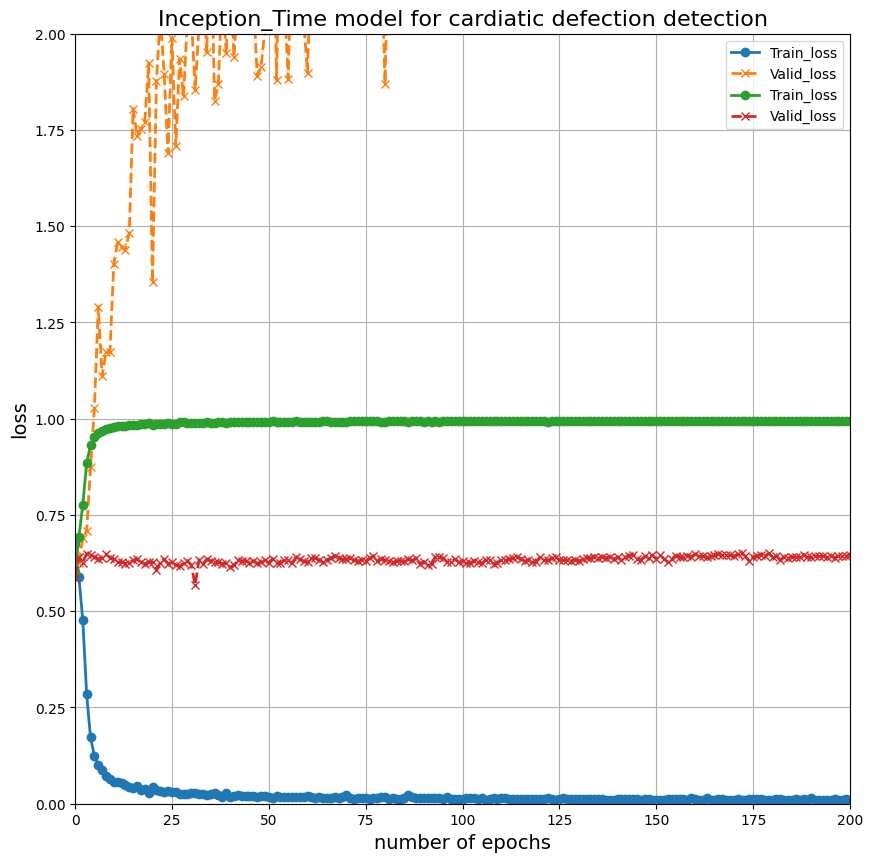

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(hist.history['loss'],label ="Train_loss",linestyle='solid', linewidth = 2,marker='o', markersize=6)
plt.plot(hist.history['val_loss'],label ="Valid_loss",linestyle='--', linewidth = 2,marker='x', markersize=6)
plt.plot(hist.history['accuracy'],label ="Train_loss",linestyle='solid', linewidth = 2,marker='o', markersize=6)
plt.plot(hist.history['val_accuracy'],label ="Valid_loss",linestyle='--', linewidth = 2,marker='x', markersize=6)
plt.gca().set_xlim(0, 200)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.xlabel('number of epochs', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('Inception_Time model for cardiatic defection detection',fontsize=16)
plt.legend()
plt.grid(True)

plt.show()